# Usage (details: theoretical datasets)
Here, we will create an example dataset with theoretical values of SIR-derived model. Then, we will perform scenario analysis with it.

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
from pprint import pprint

In [3]:
import covsirphy as cs
cs.__version__

'2.6.0-beta.fix.120.155'

In [4]:
# Instance to save population values
population_data = cs.PopulationData(filename=None)
population_data.cleaned()

,ISO3,Country,Province,Date,Population


## Create example dataset with theoretical values
We will use `ExampleData` class to produce theoretical values. Model descriptions (`SIR` class etc.) have preset of parameter values. Then, $\tau$ (coeficient for non-dimensionalization) will be set as $1440\ \mathrm{[min]}$. The first date of records will be 01Jan2020 as an example.

In [5]:
# Set tau value and start date of records
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


`ExampleData` class is a child class of `JHUData`. This means that we can use the example data in scenario analysis. Example codes will be shown in "Scenario analysis with theoretical data" subsection.

In [6]:
issubclass(cs.ExampleData, cs.JHUData)

True

In [7]:
isinstance(example_data, cs.JHUData)

True

## SIR model
Let's start with simle SIR model. Details of models are explained in [Kaggle: COVID-19 data with SIR model](https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model#SIR-to-SIR-F).
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
\end{align*}

Note:  
Though R in SIR model is "Recovered and have immunity", We defines "R as Recovered or fatal". This is because mortality rate cannot be ignored in the real COVID-19 data.

In [8]:
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE)

SIR

{

'param_dict'

: 

{'rho': 0.2, 'sigma': 0.075}

,
 

'population'

: 

1000000

,
 

'step_n'

: 

180

,
 

'y0_dict'

: 

{'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}

}

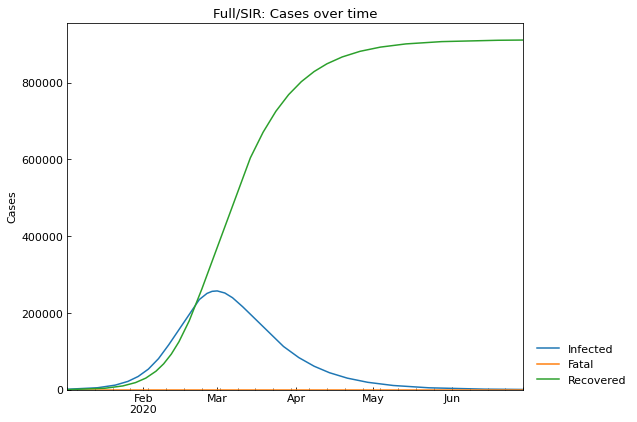

,Date,Confirmed,Infected,Fatal,Recovered
176,2020-06-25,911645,750,0,910895
177,2020-06-26,911658,708,0,910950
178,2020-06-27,911671,669,0,911002
179,2020-06-28,911682,632,0,911050
180,2020-06-29,911692,596,0,911096


In [9]:
area = {"country": "Full", "province": cs.SIR.NAME}
# Add records with SIR model
example_data.add(cs.SIR, **area)
# Register population value
population_data.update(cs.SIR.EXAMPLE["population"], **area)
# Show records with Scenario class
scenario = cs.Scenario(example_data, population_data, **area)
scenario.records().tail()

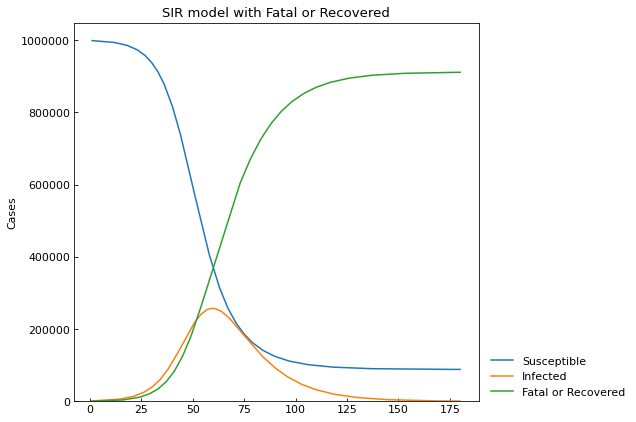

In [10]:
df = cs.SIR.specialize(scenario.records(show_figure=False), population=1000000)
cs.line_plot(
    df[["Susceptible", "Infected", "Fatal or Recovered"]],
    title="SIR model with Fatal or Recovered",
    y_integer=True
)

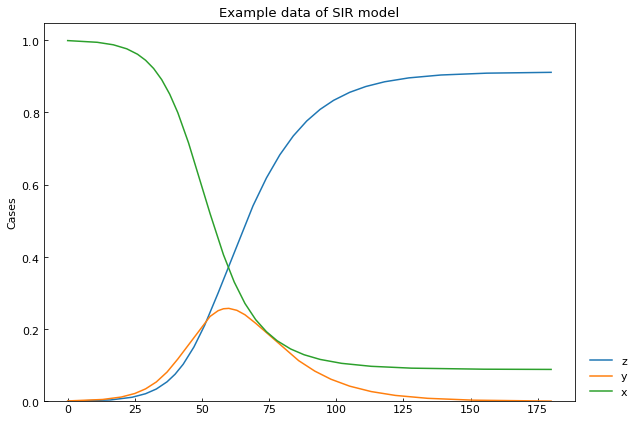

In [11]:
# Non-dimensional values
cs.line_plot(
    example_data.non_dim(country="Full", province=cs.SIR.NAME).set_index("t"),
    title="Example data of SIR model"
)

## SIR-D model
Because we are measuring the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.
\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

In [12]:
# Model name
print(cs.SIRD.NAME)
# Example parameter values
pprint(cs.SIRD.EXAMPLE)

SIR-D

{

'param_dict'

: 

{'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075}

,
 

'population'

: 

1000000

,
 

'step_n'

: 

180

,
 

'y0_dict'

: 

{

'Fatal'

: 

0

,
             

'Infected'

: 

1000

,
             

'Recovered'

: 

0

,
             

'Susceptible'

: 

999000

}

}

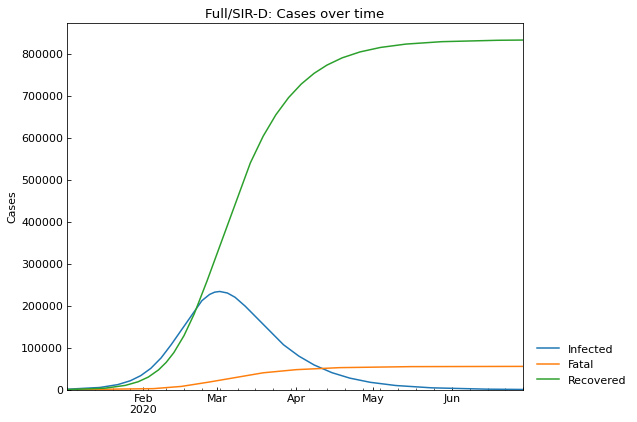

,Date,Confirmed,Infected,Fatal,Recovered
176,2020-06-25,888746,710,55502,832534
177,2020-06-26,888762,670,55506,832586
178,2020-06-27,888776,632,55509,832635
179,2020-06-28,888790,597,55512,832681
180,2020-06-29,888802,563,55515,832724


In [13]:
area = {"country": "Full", "province": cs.SIRD.NAME}
# Add records with SIR-D model
example_data.add(cs.SIRD, **area)
# Register population value
population_data.update(cs.SIRD.EXAMPLE["population"], **area)
# Show records with Scenario class
scenario = cs.Scenario(example_data, population_data, **area)
scenario.records().tail()

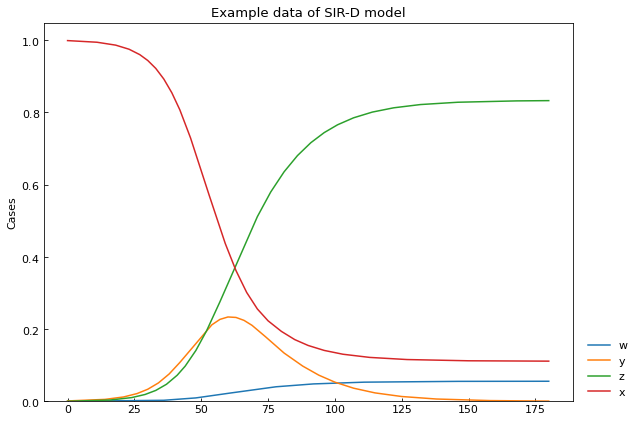

In [14]:
# Non-dimensional values
cs.line_plot(
    example_data.non_dim(country="Full", province=cs.SIRD.NAME).set_index("t"),
    title="Example data of SIR-D model"
)

## SIR-F model
It is reported that some cases died before clinical diagnosis of COVID-19. To consider this issue, "S + I $\to$ Fatal + I" will be added to the model. When $\alpha_{1}=0$, SIR-F model will be the same as SIR-D model.
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

In [15]:
# Model name
print(cs.SIRF.NAME)
# Example parameter values
pprint(cs.SIRF.EXAMPLE)

SIR-F

{

'param_dict'

: 

{'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002}

,
 

'population'

: 

1000000

,
 

'step_n'

: 

180

,
 

'y0_dict'

: 

{

'Fatal'

: 

0

,
             

'Infected'

: 

1000

,
             

'Recovered'

: 

0

,
             

'Susceptible'

: 

999000

}

}

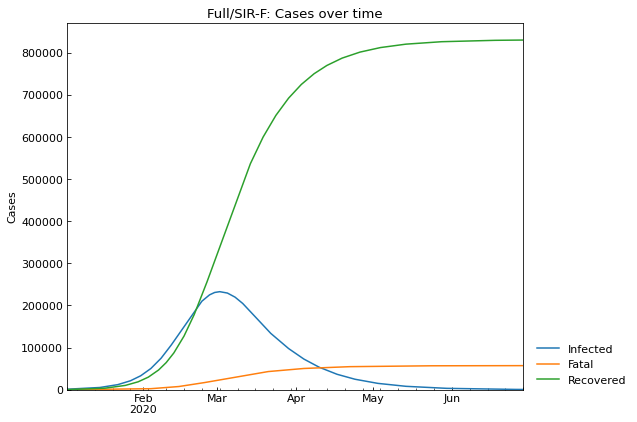

,Date,Confirmed,Infected,Fatal,Recovered
176,2020-06-25,887764,723,57103,829938
177,2020-06-26,887779,683,57106,829990
178,2020-06-27,887795,645,57110,830040
179,2020-06-28,887809,609,57113,830087
180,2020-06-29,887821,574,57116,830131


In [16]:
area = {"country": "Full", "province": cs.SIRF.NAME}
# Add records with SIR-F model
example_data.add(cs.SIRF, **area)
# Register population value
population_data.update(cs.SIRF.EXAMPLE["population"], **area)
# Show records with Scenario class
scenario = cs.Scenario(example_data, population_data, **area)
scenario.records().tail()

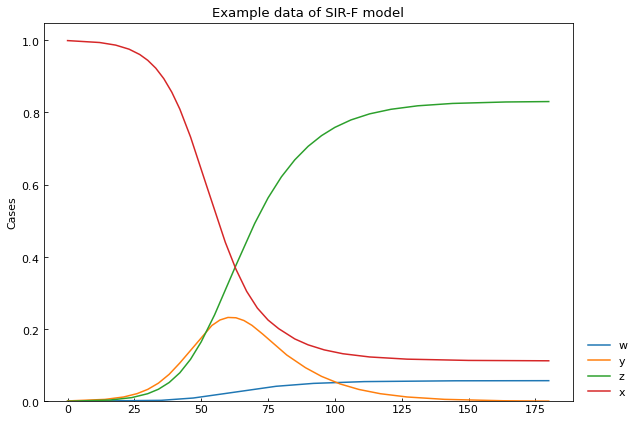

In [17]:
# Non-dimensional values
cs.line_plot(
    example_data.non_dim(country="Full", province=cs.SIRF.NAME).set_index("t"),
    title="Example data of SIR-F model"
)

## SEWIR-F model (SIR-F with exposed/waiting cases)
The number of exposed cases in latent period (E) and wating cases for confirmation (W) are un-measurable variables, but key variables as well as S, I, R, F. If E and W are large, outbreak will occur in the near future. Let's replace S$\overset{\beta I}{\longrightarrow}$S$^\ast$ as follows because W also has infectivity.
\begin{align*}
\mathrm{S} \overset{\beta_1 (W+I)}{\longrightarrow} \mathrm{E} \overset{\beta_2}{\longrightarrow} \mathrm{W} \overset{\beta_3}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

In [18]:
# Model name
print(cs.SEWIRF.NAME)
# Example parameter values
pprint(cs.SEWIRF.EXAMPLE)

SEWIR-F

{

'param_dict'

: 

{

'kappa'

: 

0.005

,
                

'rho1'

: 

0.2

,
                

'rho2'

: 

0.167

,
                

'rho3'

: 

0.167

,
                

'sigma'

: 

0.075

,
                

'theta'

: 

0.002

}

,
 

'population'

: 

1000000

,
 

'step_n'

: 

180

,
 

'y0_dict'

: 

{

'Exposed'

: 

3000

,
             

'Fatal'

: 

0

,
             

'Infected'

: 

1000

,
             

'Recovered'

: 

0

,
             

'Susceptible'

: 

994000

,
             

'Waiting'

: 

0.002

}

}

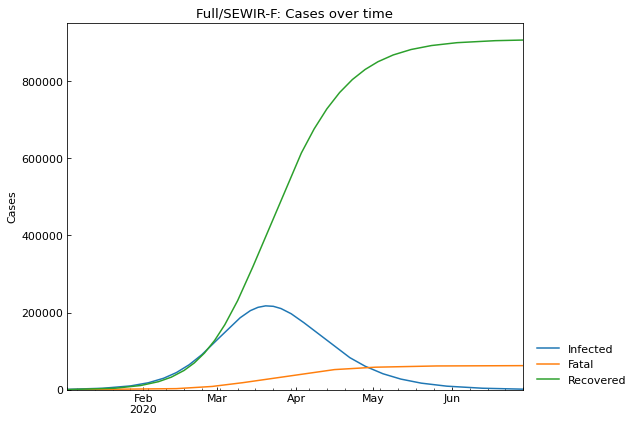

,Date,Confirmed,Infected,Fatal,Recovered
176,2020-06-25,969902,1771,62325,905806
177,2020-06-26,969930,1661,62334,905935
178,2020-06-27,969956,1559,62342,906055
179,2020-06-28,969980,1462,62349,906169
180,2020-06-29,970003,1372,62356,906275


In [19]:
area = {"country": "Full", "province": cs.SEWIRF.NAME}
# Add records with SIR-F model
example_data.add(cs.SEWIRF, **area)
# Register population value
population_data.update(cs.SEWIRF.EXAMPLE["population"], **area)
# Show records with Scenario class
scenario = cs.Scenario(example_data, population_data, **area)
scenario.records().tail()

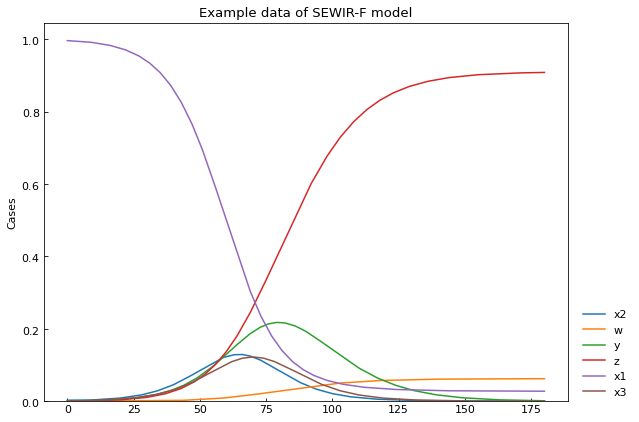

In [20]:
# Non-dimensional values
cs.line_plot(
    example_data.non_dim(country="Full", province=cs.SEWIRF.NAME).set_index("t"),
    title="Example data of SEWIR-F model"
)

## SIR-FV model (SIR-F model with vaccination)
This model considers vacctnation of sussceptible people as follows. $\omega \times N$ persons will be vaccinated in a day. $N$ is the total population.
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

With
$$
\frac{\mathrm{d}S}{\mathrm{d}T}= - \beta S I - \omega N  \\
$$

In [21]:
# Model name
print(cs.SIRFV.NAME)
# Example parameter values
pprint(cs.SIRFV.EXAMPLE)

SIR-FV

{

'param_dict'

: 

{

'kappa'

: 

0.005

,
                

'omega'

: 

0.001

,
                

'rho'

: 

0.2

,
                

'sigma'

: 

0.075

,
                

'theta'

: 

0.002

}

,
 

'population'

: 

1000000

,
 

'step_n'

: 

180

,
 

'y0_dict'

: 

{

'Fatal'

: 

0

,
             

'Infected'

: 

1000

,
             

'Recovered'

: 

0

,
             

'Susceptible'

: 

999000

,
             

'Vaccinated'

: 

0

}

}

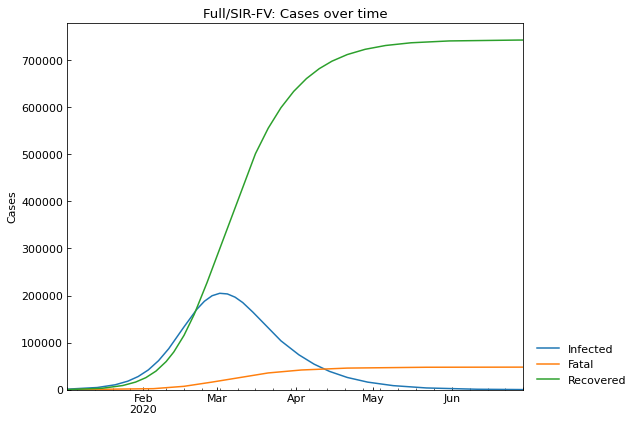

,Date,Confirmed,Infected,Fatal,Recovered
176,2020-06-25,790566,347,47908,742311
177,2020-06-26,790568,322,47910,742336
178,2020-06-27,790569,299,47911,742359
179,2020-06-28,790572,278,47913,742381
180,2020-06-29,790573,258,47914,742401


In [22]:
area = {"country": "Full", "province": cs.SIRFV.NAME}
# Add records with SIR-F model
example_data.add(cs.SIRFV, **area)
# Register population value
population_data.update(cs.SIRFV.EXAMPLE["population"], **area)
# Show records with Scenario class
scenario = cs.Scenario(example_data, population_data, **area)
scenario.records().tail()

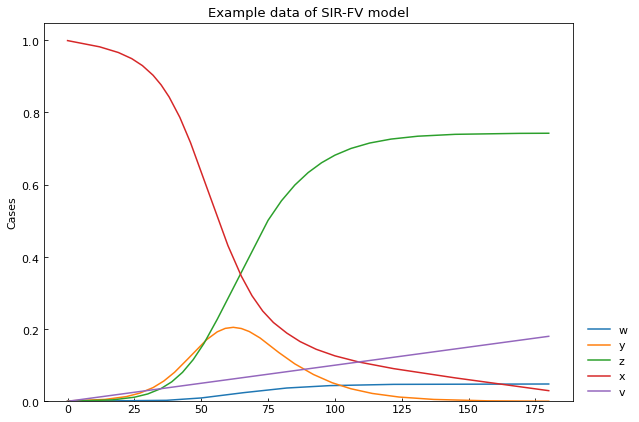

In [23]:
# Non-dimensional values
cs.line_plot(
    example_data.non_dim(country="Full", province=cs.SIRFV.NAME).set_index("t"),
    title="Example data of SIR-FV model"
)

## Scenario analysis with theoretical data
Because `ExampleData` class is a subclass of `JHUData`, we can perform scenario analysis with example datasets easily. Here, we will use the following scenarios. For explanation, $\tau=1440$, the start date is 01Jan2020, population is 1,000,000 and country name is "Theoretical". This is not based on actual data.

| name | 01Jan2020 - 31Jan2020 | 01Feb2020 - 31Dec2020 |
|:---:|:---:|:---|
| Main | SIR-F | SIR-F|
| Lockdown | SIR-F | SIR-F with half value of $\rho$ |
| Medicine | SIR-F | SIR-F with half value of $\kappa$ and double value of $\sigma$ |
| Vaccine | SIR-F | SIR-FV with $\omega=0.001$|

In [24]:
# Preset of SIR-F parameters
preset_dict = cs.SIRF.EXAMPLE["param_dict"]
preset_dict

{'theta': 0.002, 'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075}

In [25]:
area = {"country": "Theoretical"}
# Create dataset from 01Jan2020 to 31Jan2020
example_data.add(cs.SIRF, step_n=30, **area)
# Register population value
population_data.update(cs.SIRF.EXAMPLE["population"], **area)
population_data.value(**area)

1000000

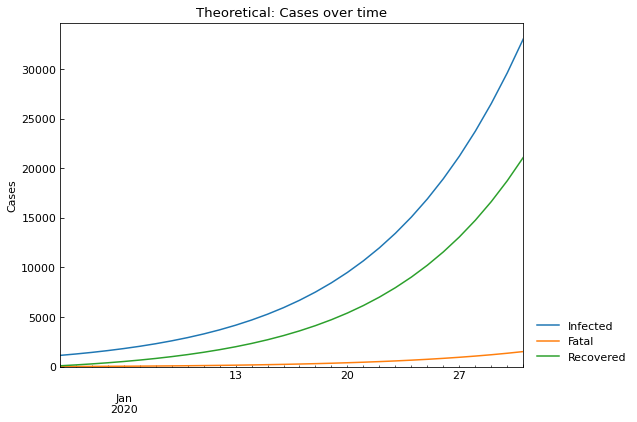

,Date,Confirmed,Infected,Fatal,Recovered
1,2020-01-02,1213,1127,6,80
2,2020-01-03,1451,1270,12,169
3,2020-01-04,1720,1430,19,271
4,2020-01-05,2025,1612,28,385
5,2020-01-06,2366,1816,37,513


,Date,Confirmed,Infected,Fatal,Recovered
26,2020-01-27,35218,21210,940,13068
27,2020-01-28,39544,23730,1061,14753
28,2020-01-29,44357,26524,1196,16637
29,2020-01-30,49704,29616,1347,18741
30,2020-01-31,55633,33030,1515,21088


In [26]:
# Show records with Scenario class
snl = cs.Scenario(example_data, population_data, tau=1440, **area)
record_df = snl.records()
display(record_df.head())
display(record_df.tail())

Note:  
Record on 01Jan2020 was removed because the number of recovered cases is 0 and this sometimes causes error in estimation.

In [27]:
# Set 0th phase from 02Jan2020 to 31Jan2020 with preset parameter values
snl.clear(include_past=True)
snl.add(end_date="31Jan2020", model=cs.SIRF, **preset_dict)
snl.summary()

,Type,Start,End,Population,tau,ODE,theta,kappa,rho,sigma,Rt,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
0th,Past,02Jan2020,31Jan2020,1000000,1440,SIR-F,0.002,0.005,0.2,0.075,2.5,0.002,200,5,13


In [28]:
# Add main scenario
snl.add(end_date="31Dec2020", name="Main")
# Add lockdown scenario
rho_lock = snl.get("rho", phase="0th") / 2
snl.add(end_date="31Dec2020", name="Lockdown", rho=rho_lock)
# Add medicine scenario
kappa_med = snl.get("kappa", phase="0th") / 2
sigma_med = snl.get("sigma", phase="0th") * 2
snl.add(end_date="31Dec2020", name="Medicine", kappa=kappa_med, sigma=sigma_med)
# Add vaccine scenario
snl.add(end_date="31Dec2020", name="Vaccine", model=cs.SIRFV, omega=0.001)
# Summarize
snl.summary()

Type      Start        End  Population   tau     ODE  theta  \
Scenario Phase                                                                  
Main     0th      Past  02Jan2020  31Jan2020     1000000  1440   SIR-F  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  1440   SIR-F  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  1440   SIR-F  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  1440   SIR-F  0.002   
Medicine 0th      Past  02Jan2020  31Jan2020     1000000  1440   SIR-F  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  1440   SIR-F  0.002   
Vaccine  0th      Past  02Jan2020  31Jan2020     1000000  1440   SIR-F  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  1440  SIR-FV  0.002   

                 kappa  rho  sigma    Rt alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                        
Main     0th    0.0050  0.2  0.075  2.50      0.002             200   
         1st    0.0050  0.2  0.075  2.50      0.002             200   
Lockdown 0th    0.0050  0.2  0.075  2.50      0.002             200   
         1st    0.0050  0.1  0.075  1.25      0.002             200   
Medicine 0th    0.0050  0.2  0.075  2.50      0.002             200   
         1st    0.0025  0.2  0.150  1.31      0.002             400   
Vaccine  0th    0.0050  0.2  0.075  2.50      0.002             200   
         1st    0.0050  0.2  0.075  2.50          -             200   

                1/beta [day]  1/gamma [day]  omega alpha1 Vaccinated [persons]  
Scenario Phase                                                                  
Main     0th               5             13    NaN    NaN                  NaN  
         1st               5             13    NaN    NaN                  NaN  
Lockdown 0th               5             13    NaN    NaN                  NaN  
         1st              10             13    NaN    NaN                  NaN  
Medicine 0th               5             13    NaN    NaN                  NaN  
         1st               5              6    NaN    NaN                  NaN  
Vaccine  0th               5             13      -      -                    -  
         1st               5             13  0.001  0.002                 1000

### Compare the scenarios

In [29]:
# Apply initial value of Vaccinated because this variable is not included in first model (SIR-F)
snl.describe(y0_dict={"Vaccinated": 0})

,max(Infected),argmax(Infected),Infected on 31Dec2020,Fatal on 31Dec2020
Main,232568,02Mar2020,0,57398
Lockdown,47079,08Mar2020,109,28555
Medicine,53837,22Feb2020,0,10181
Vaccine,223130,02Mar2020,0,50726


### Simulation of each scenario

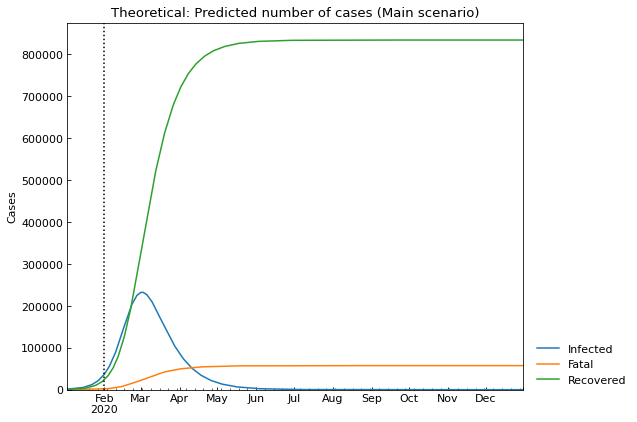

In [30]:
_ = snl.simulate(name="Main")

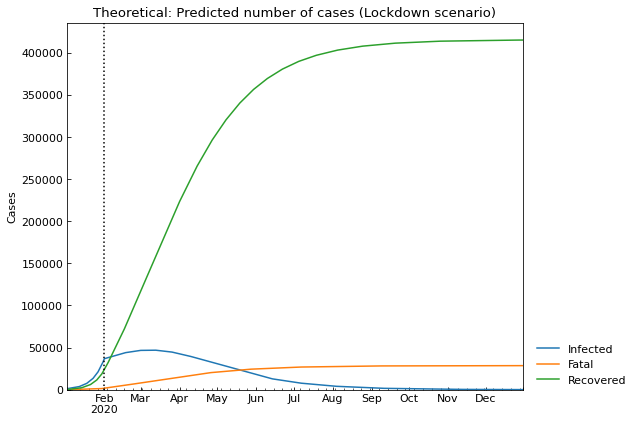

In [31]:
_ = snl.simulate(name="Lockdown")

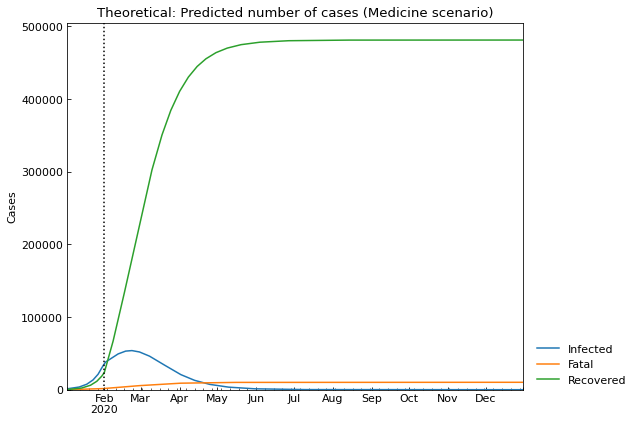

In [32]:
_ = snl.simulate(name="Medicine")

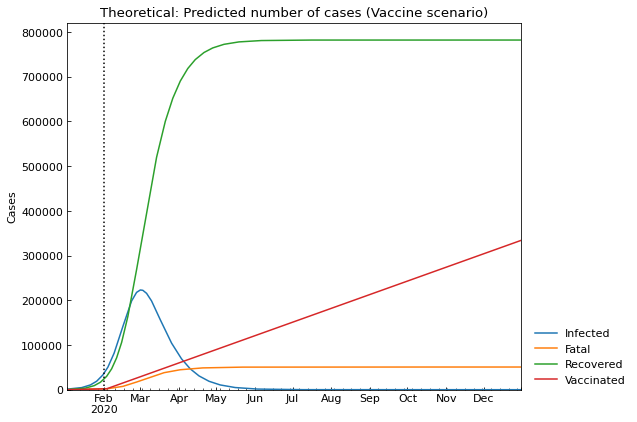

In [33]:
_ = snl.simulate(name="Vaccine", y0_dict={"Vaccinated": 0})